In [1]:
# source: https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp, wasserstein_distance

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
df = pd.read_csv(url, sep=";", compression="zip", low_memory=False, na_values="?")
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")
df = df.dropna(subset=["Global_active_power"])

In [4]:
df_daily = df.groupby("Date")["Global_active_power"].mean().reset_index()

In [5]:
np.random.seed(42)
days = len(df_daily)
time_index = pd.date_range(start=df_daily["Date"].min(), periods=days, freq="D")

trend = np.linspace(0, 0.5, days)

seasonality = (
    0.6 * np.sin(2 * np.pi * np.arange(days) / 365) + 
    0.3 * np.sin(2 * np.pi * np.arange(days) / 180)
)

noise = np.zeros(days)
for t in range(1, days):
    noise[t] = 0.7 * noise[t-1] + np.random.normal(0, 0.2)

synthetic_power = 1.0 + trend + seasonality + noise

df_synth_timeseries = pd.DataFrame({
    "Date": time_index,
    "Global_active_power": synthetic_power
})

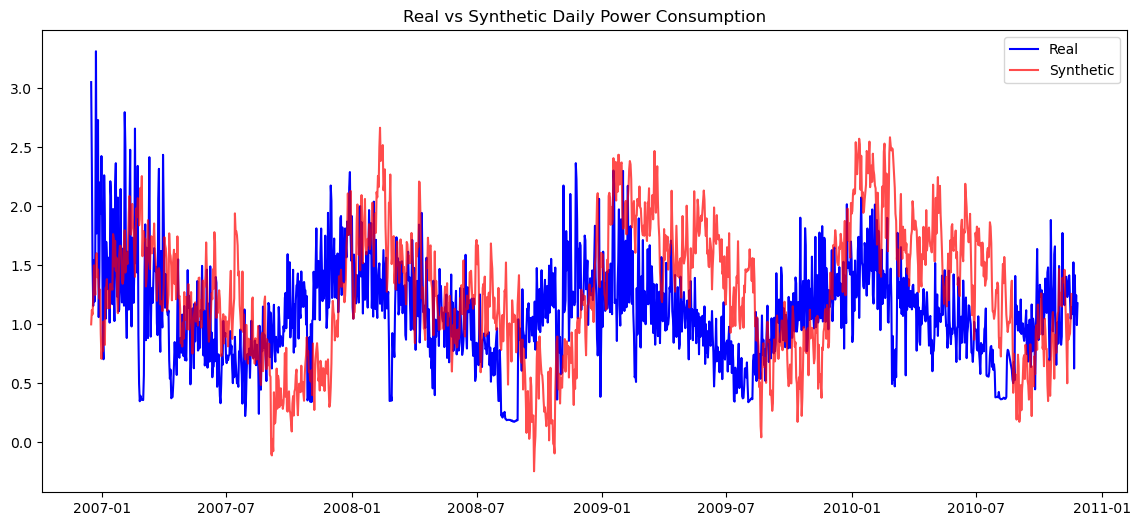

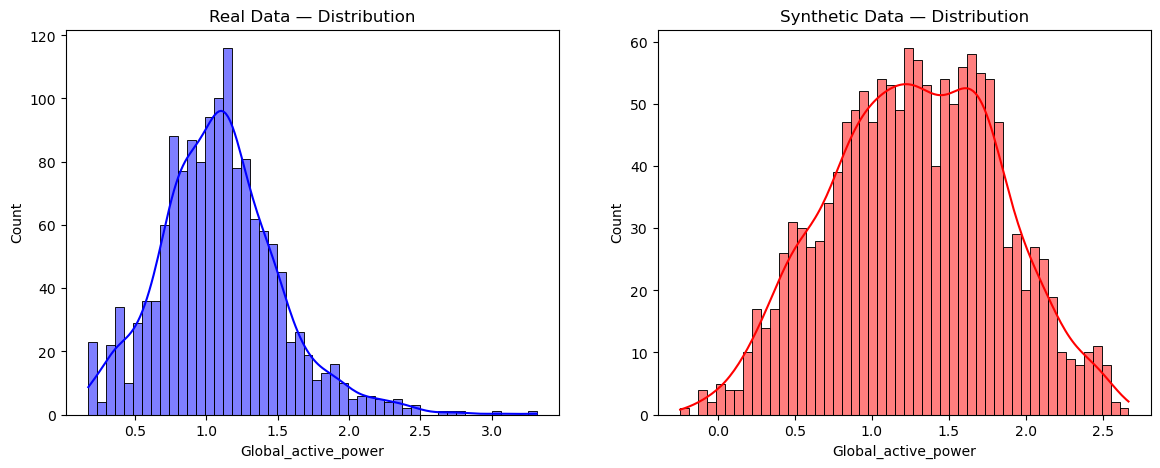

In [6]:
plt.figure(figsize=(14,6))
plt.plot(df_daily["Date"], df_daily["Global_active_power"], label="Real", color="blue")
plt.plot(df_synth_timeseries["Date"], df_synth_timeseries["Global_active_power"], label="Synthetic", color="red", alpha=0.7)
plt.legend()
plt.title("Real vs Synthetic Daily Power Consumption")
plt.show()

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.histplot(df_daily["Global_active_power"], bins=50, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Real Data — Distribution")
sns.histplot(df_synth_timeseries["Global_active_power"], bins=50, kde=True, ax=axes[1], color="red")
axes[1].set_title("Synthetic Data — Distribution")
plt.show()

In [7]:
ks_power = ks_2samp(df_daily["Global_active_power"], df_synth_timeseries["Global_active_power"])
wd_power = wasserstein_distance(df_daily["Global_active_power"], df_synth_timeseries["Global_active_power"])

print("Kolmogorov-Smirnov (Global Active Power):", ks_power)
print("Wasserstein distance (Global Active Power):", wd_power)
print("Real mean:", df_daily["Global_active_power"].mean())
print("Synthetic mean:", df_synth_timeseries["Global_active_power"].mean())
print("Real std:", df_daily["Global_active_power"].std())
print("Synthetic std:", df_synth_timeseries["Global_active_power"].std())

Kolmogorov-Smirnov (Global Active Power): KstestResult(statistic=0.23656664340544312, pvalue=1.420550198364339e-35, statistic_location=1.4362127659574468, statistic_sign=1)
Wasserstein distance (Global Active Power): 0.20746892960718755
Real mean: 1.09204830160128
Synthetic mean: 1.2779923316938815
Real std: 0.42041545939312147
Synthetic std: 0.5475255126713887


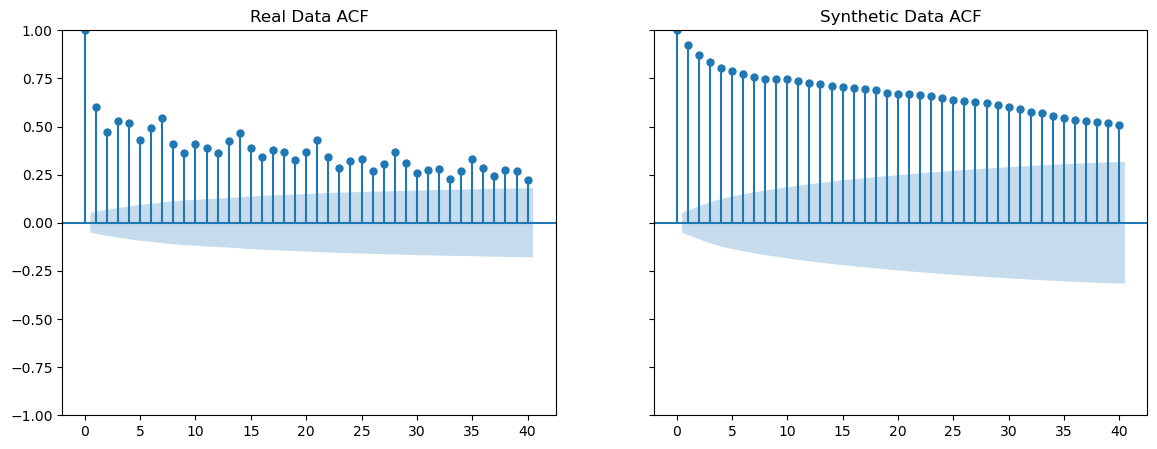

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
plot_acf(df_daily["Global_active_power"], lags=40, ax=axes[0], title="Real Data ACF")
plot_acf(df_synth_timeseries["Global_active_power"], lags=40, ax=axes[1], title="Synthetic Data ACF")
plt.show()

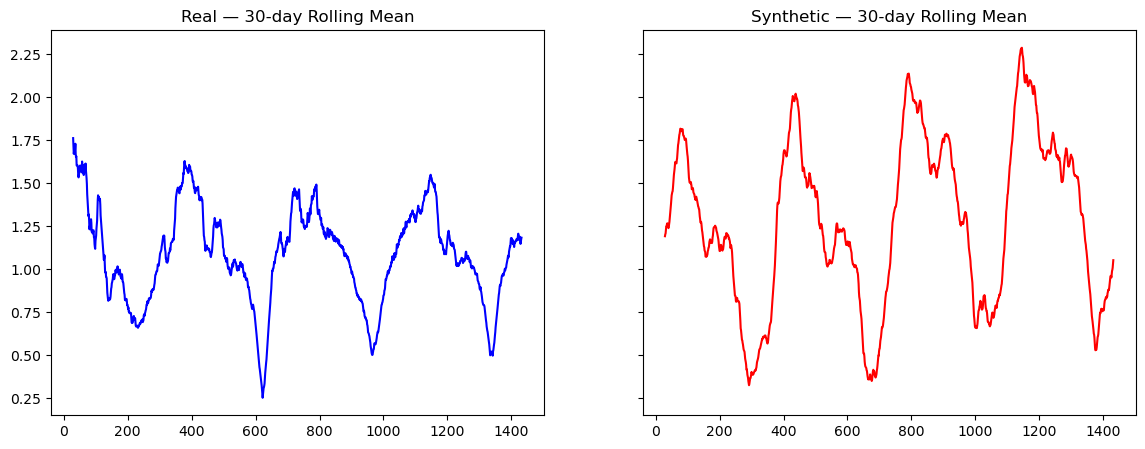

In [9]:
window = 30  # 1 month
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)

df_daily["Global_active_power"].rolling(window).mean().plot(ax=axes[0], color="blue")
axes[0].set_title("Real — 30-day Rolling Mean")

df_synth_timeseries["Global_active_power"].rolling(window).mean().plot(ax=axes[1], color="red")
axes[1].set_title("Synthetic — 30-day Rolling Mean")

plt.show()

In [10]:
#df_daily.to_csv("real_power_data.csv", index=False)
#df_synth_timeseries.to_csv("synthetic_power_data.csv", index=False)